# パルマーペンギンデータセットを例にPyTorchの使い方を学ぼう

ニューラルネットワークの実装のためのライブラリ「PyTorch」の使い方を，penguinデータセットのクラス分類を例に学ぼう．

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import random
import os

In [10]:
SEED = 20220725

# seed function for reproducibility
def set_seed(seed: int=0):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

## SECTION 1 : 学習用データのロードとセットアップ  

- [ペンギンデータについて](https://penguinchord.com/blog/data-science/python-palmerpenguins-engineering) 
![](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)

[オリジンデータをもとに2つのファイルに分けたデータセット](https://github.com/rianrajagede/penguin-python/tree/master/Datasets) 。   
- penguin-clean-train.csv = 学習用データセット、オリジナルデータから70%使用。  
- penguin-clean-test.csv = テスト用データセット、オリジナルデータから30%抽出  

>SECTION 1 : Load and setup data for training  
the datasets separated in two files from originai datasets:  
penguin-clean-train.csv = datasets for training purpose, 70% from the original data  
penguin-clean-test.csv  = datasets for testing purpose, 30% from the original data  

### Section 1.1 Data Loading

データセットは前処理済みのものが既にあるので、これを直接利用する https://github.com/rianrajagede/penguin-python/tree/master/Datasets

In [11]:
en2ja = {
    "species": "ペンギンの種類",
    "island": "生息する島",
    "bill_length_mm": "クチバシの長さ",
    "bill_depth_mm":"クチバシの厚み",
    "flipper_length_mm": "翼の長さ",
    "body_mass_g": "体重",
    "sex": "性別",
    "year": "調査年",
}

In [12]:
#load

dataset_url = "https://raw.githubusercontent.com/rianrajagede/penguin-python/master/Datasets/penguins-clean-all.csv"
training_url = "https://raw.githubusercontent.com/rianrajagede/penguin-python/master/Datasets/penguins-clean-train.csv"
test_url = "https://raw.githubusercontent.com/rianrajagede/penguin-python/master/Datasets/penguins-clean-test.csv"
# datatrain = pd.read_csv('../Datasets/penguins-clean-train.csv')
df_train = pd.read_csv(training_url)

In [13]:
df_train.shape

(240, 5)

In [14]:
df_train_ja = df_train.copy()
df_train_ja.columns = [en2ja[key] for key in df_train_ja.columns]
df_train_ja

,ペンギンの種類,クチバシの長さ,クチバシの厚み,翼の長さ,体重
0,Gentoo,46.2,14.5,209,4800
1,Gentoo,43.6,13.9,217,4900
2,Gentoo,45.3,13.7,210,4300
3,Gentoo,53.4,15.8,219,5500
4,Adelie,40.6,18.8,193,3800
...,...,...,...,...,...
235,Gentoo,46.8,15.4,215,5150
236,Gentoo,46.6,14.2,210,4850
237,Gentoo,43.5,14.2,220,4700
238,Gentoo,46.9,14.6,222,4875


In [15]:
#Section 1.2 Preprocessing

#change string value to numeric
df_train.loc[df_train['species']=='Adelie', 'species']=0
df_train.loc[df_train['species']=='Gentoo', 'species']=1
df_train.loc[df_train['species']=='Chinstrap', 'species']=2
df_train = df_train.apply(pd.to_numeric)

#change dataframe to array
df_array = df_train.values

#split x and y (feature and target)
X_train = df_array[:,1:]
y_train = df_array[:,0]

#standardize
#palmer-penguin dataset has varying scales
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## SECTION 2 : モデルの構築と学習

- 隠れ層を1層持つ、多層パーセプトロンモデル。  
- 入力層：4ニューロン、Palmer Penguinデータセットからの特徴を表す。  
- 隠れ層：20ニューロン、ReLUで活性化  
- 出力層：3ニューロン、種の数を表す、Softmax Layer  
- 最適化器 = 確率的勾配降下法、バッチサイズなし  
- 損失関数 = カテゴリクロスエントロピー  
- 学習率 = 0.01  
- エポック = 50  

>SECTION 2 : Build and Train Model  
Multilayer perceptron model, with one hidden layer.  
input layer : 4 neuron, represents the feature from Palmer Penguin dataset  
hidden layer : 20 neuron, activation using ReLU
output layer : 3 neuron, represents the number of species, Softmax Layer
optimizer = stochastic gradient descent with no batch-size  
loss function = categorical cross entropy  
learning rate = 0.01  #hyperparameters
hl = 20
lr = 0.01
num_epoch = 100

epoch = 50  

In [16]:
#hyperparameters
hl = 20
lr = 0.01
num_epoch = 100

ネットワークはnn.Sequentialを使って作るパターンと，nn.Moduleを継承したクラスを作るパターンがある．

In [17]:
mynet = nn.Sequential(
    nn.Linear(4, 20,),
    nn.ReLU(),
    nn.Linear(20, 3),
    nn.Softmax(dim=1)
)

In [18]:
#build model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, hl)
        self.fc2 = nn.Linear(hl, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
#choose optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

In [19]:
print("training data:",type(X_train), X_train.shape, X_train.dtype)
print("test data:", type(y_train), y_train.shape, y_train.dtype)

training data: <class 'torch.Tensor'> torch.Size([240, 4]) torch.float32
test data: <class 'torch.Tensor'> torch.Size([240]) torch.int64


In [20]:
net.eval()
print(net.training
)
net.train()
print(net.training
)

False
True


訓練ループ

In [21]:
# logging
logs = {"loss":[], "acc":[]}

#train
if torch.cuda.is_available():
  net = net.to("cuda:0")
  X_train = X_train.to("cuda:0")
  y_train = y_train.to("cuda:0")

for epoch in range(num_epoch):

    #feedforward - backprop
    # 勾配の初期化
    optimizer.zero_grad()
    # フォワードプロップ。順伝搬
    out = net(X_train)
    # 損失関数の計算
    loss = criterion(out, y_train)
    # 逆伝搬して、各パラメータの勾配を求める
    loss.backward()
    # 勾配を使って学習可能パラメータの値を更新
    optimizer.step()

    with torch.no_grad():
        acc = 100 * torch.sum(y_train==torch.max(out.data, 1)[1]).double() / len(y_train)
    print ('Epoch [%d/%d] Loss: %.4f   Acc: %.4f'
                   %(epoch+1, num_epoch, loss.item(), acc.item()))

    # logging
    logs["loss"] += [loss.cpu().detach().item()]
    logs["acc"]  += [acc.cpu().detach().item()]

Epoch [1/100] Loss: 1.1014   Acc: 42.9167
Epoch [2/100] Loss: 1.0938   Acc: 44.1667
Epoch [3/100] Loss: 1.0864   Acc: 46.2500
Epoch [4/100] Loss: 1.0790   Acc: 49.1667
Epoch [5/100] Loss: 1.0718   Acc: 51.6667
Epoch [6/100] Loss: 1.0646   Acc: 52.5000
Epoch [7/100] Loss: 1.0575   Acc: 55.4167
Epoch [8/100] Loss: 1.0505   Acc: 55.4167
Epoch [9/100] Loss: 1.0436   Acc: 59.1667
Epoch [10/100] Loss: 1.0367   Acc: 60.4167
Epoch [11/100] Loss: 1.0300   Acc: 62.5000
Epoch [12/100] Loss: 1.0233   Acc: 66.2500
Epoch [13/100] Loss: 1.0167   Acc: 67.5000
Epoch [14/100] Loss: 1.0102   Acc: 68.3333
Epoch [15/100] Loss: 1.0037   Acc: 70.4167
Epoch [16/100] Loss: 0.9973   Acc: 71.2500
Epoch [17/100] Loss: 0.9910   Acc: 72.9167
Epoch [18/100] Loss: 0.9848   Acc: 73.7500
Epoch [19/100] Loss: 0.9786   Acc: 74.1667
Epoch [20/100] Loss: 0.9725   Acc: 75.8333
Epoch [21/100] Loss: 0.9664   Acc: 75.8333
Epoch [22/100] Loss: 0.9604   Acc: 76.2500
Epoch [23/100] Loss: 0.9545   Acc: 76.2500
Epoch [24/100] Loss:

学習中の損失関数のモニタリング

<Axes: >

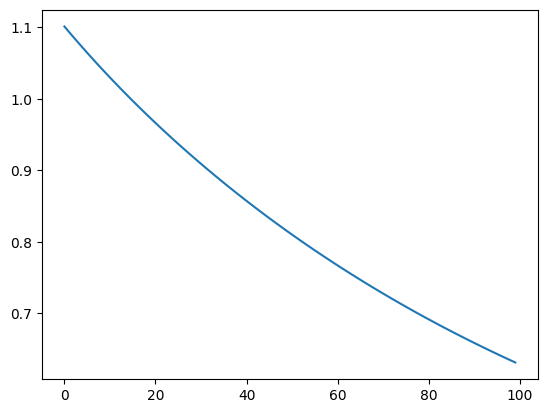

In [22]:
pd.DataFrame(logs)["loss"].plot()

学習中の正答率のモニタリング

<Axes: >

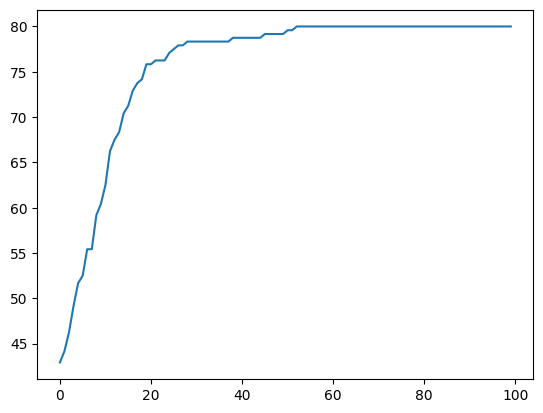

In [23]:
pd.DataFrame(logs)["acc"].plot()

## SECTION 3 : モデルの評価

In [24]:
#load
df_test = pd.read_csv(test_url)

#change string value to numeric
df_test.loc[df_test['species']=='Adelie', 'species']=0
df_test.loc[df_test['species']=='Gentoo', 'species']=1
df_test.loc[df_test['species']=='Chinstrap', 'species']=2
df_test = df_test.apply(pd.to_numeric)

#change dataframe to array
df_test_array = df_test.values

#split x and y (feature and target)
X_test = df_test_array[:,1:]
y_test = df_test_array[:,0]

#standardization
X_test = scaler.transform(X_test)

#get prediction
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

# 必要ならばCPUからGPUへ配列を移動
#X_test = X_test.to(X_train.device)
#y_test = y_test.to(y_train.device)

if torch.cuda.is_available():
  X_test = X_test.cuda()
  y_test = y_test.cuda()

#テストデータに対するクラスラベルの予測
out = net.forward(X_test)#.softmax(1)
_, predicted = torch.max(out.data, 1)

#get accuration
print('Accuracy of the network %.4f %%' % (100 * torch.sum(y_test==predicted).double() / len(y_test)))

Accuracy of the network 80.3922 %


### [課題1] 入力層の次元数と隠れ層の次元数とクラス数を__init__の引数で変更できるようにNetクラスを修正せよ。


In [ ]:
class FixedNet(nn.Module):

    def __init__(self, num_features, hidden_size, num_class):
        super().__init__()
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_features = X_train.shape[1]
hidden_size = 100
num_class = 3
fixed_net = FixedNet(num_features,hidden_size, num_class)
fixed_net

FixedNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)

### [課題2] 課題1で作ったクラスを使って，クラス数をそのままに隠れ層の次元数を100にして200エポック訓練せよ．また，その際のtestデータの正答率を示せ．この際、set_seedを使いSEEDを1111に固定する事．


In [ ]:
set_seed(1111)
net = FixedNet(num_features,hidden_size, num_class)
#choose optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 訓練のコード

# 評価のコード


### [課題3] ペンギンデータのクラス分類を行うニューラルネットワークを作れ。ただし、ニューラルネットワークの隠れ層は5層で、それぞれが100次元のネットワークを作成せよ。また、このニューラルネットワークの活性化関数はすべてtanhである。この隠れ層をまとめたsequentialをfeature_extractorという変数にせよ。出力層は3クラス分類を行うために次元数は3にする。


In [ ]:
class TanhNet(nn.Module):
  def __init__(self, hidden_size=100, n_class=3):
    super().__init__()
    self.feature_extractor = nn.Sequential(
          nn.Linear(4, hidden_size), # 1
          nn.Tanh(),
          nn.Linear(hidden_size, hidden_size), # 2
          nn.Tanh(),
          ... # 3
          ... # 4
          ... # 5
      )
    self.classifier = nn.Linear(hidden_size, n_class)

  def forward(self,x):
    x = self.feature_extractor(x)
    return self.classifier(x)

In [ ]:
a = TanhNet()
#a(X_train.cpu())
a

TanhNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Linear(in_features=100, out_features=3, bias=True)
)

### [課題4] 課題3で作ったクラスを使って、200エポック訓練せよ。また、その際のtestデータの正答率を提出せよ。この際、set_seedを使いSEEDを1111に固定する事。